# YOLO v7

In [1]:
%cd /content
!git clone https://github.com/derronqi/yolov7-face.git
%cd yolov7-face

/content
Cloning into 'yolov7-face'...
remote: Enumerating objects: 3784, done.
remote: Counting objects: 100% (459/459), done.
remote: Compressing objects: 100% (256/256), done.
remote: Total 3784 (delta 222), reused 417 (delta 189), pack-reused 3325
Receiving objects: 100% (3784/3784), 26.92 MiB | 31.26 MiB/s, done.
Resolving deltas: 100% (231/231), done.
/content/yolov7-face


In [2]:
!pip install gdown
!gdown https://drive.google.com/u/0/uc?id=1B2F5YuERfMEfJeRXfz5oMxI8wcZLmvFJ&export=download

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/u/0/uc?id=1B2F5YuERfMEfJeRXfz5oMxI8wcZLmvFJ
To: /content/yolov7-face/yolov7-tiny-face.pt
100% 16.1M/16.1M [00:00<00:00, 17.0MB/s]


In [3]:
!pip install onnx onnxruntime
!pip install coremltools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 13.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorboard 2.9.1 requires protobuf<3.20,>=3.9.2, but you have

In [4]:
!python3 models/export.py --weights yolov7-tiny-face.pt --export-nms --grid --simplify

Namespace(batch_size=1, device='cpu', dynamic=False, export_nms=True, grid=True, img_size=[640, 640], simplify=True, weights='yolov7-tiny-face.pt')
YOLOv5 � eabb30e torch 1.13.0+cu116 CPU

Fusing layers... 
Model Summary: 314 layers, 7826611 parameters, 0 gradients

PyTorch: starting from yolov7-tiny-face.pt (16.1 MB)

TorchScript: starting export with torch 1.13.0+cu116...
/content/yolov7-face/models/yolo.py:279: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.grid[i].shape[2:4] != x[i].shape[2:4]:
TorchScript: export success, saved as yolov7-tiny-face.torchscript.pt (31.8 MB)
ONNX: starting export with onnx 1.13.0...
/content/yolov7-face/utils/general.py:616: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of diffe

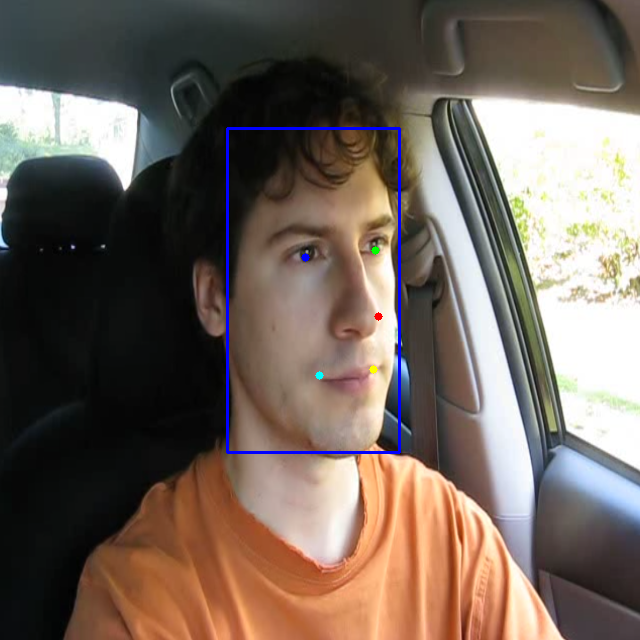

In [7]:
import onnxruntime
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from urllib.request import Request, urlopen

palette = np.array([[255, 128, 0], [255, 153, 51], [255, 178, 102],
                    [230, 230, 0], [255, 153, 255], [153, 204, 255],
                    [255, 102, 255], [255, 51, 255], [102, 178, 255],
                    [51, 153, 255], [255, 153, 153], [255, 102, 102],
                    [255, 51, 51], [153, 255, 153], [102, 255, 102],
                    [51, 255, 51], [0, 255, 0], [0, 0, 255], [255, 0, 0],
                    [255, 255, 255]])
pose_kpt_color = palette[[16, 16, 16, 16, 16, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9]]
skeleton = [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 12],
            [7, 13], [6, 7], [6, 8], [7, 9], [8, 10], [9, 11], [2, 3],
            [1, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7]]

pose_limb_color = palette[[9, 9, 9, 9, 7, 7, 7, 0, 0, 0, 0, 0, 16, 16, 16, 16, 16, 16, 16]]
radius = 5

def pre_process(img, img_mean=127.5, img_scale=1/127.5):
    img = img[:, :, ::-1]
    img = cv2.resize(img, (640,640), interpolation=cv2.INTER_LINEAR)
    img = (img - img_mean) * img_scale
    img = np.asarray(img, dtype=np.float32)
    img = np.expand_dims(img,0)
    img = img.transpose(0,3,1,2)
    return img

def model_inference(model_path=None, input=None):
    #onnx_model = onnx.load(args.model_path)
    session = onnxruntime.InferenceSession(model_path, None)
    input_name = session.get_inputs()[0].name
    output = session.run([], {input_name: input})
    return output

def post_process(img, output, score_threshold=0.3):
    """
    Draw bounding boxes on the input image. Dump boxes in a txt file.
    """
    img = cv2.resize(img, (640,640))
    det_bboxes, det_scores, det_labels, kpts = output[:, 0:4], output[:, 4], output[:, 5], output[:, 6:]
    clors = [(255,0,0),(0,255,0),(0,0,255),(255,255,0),(0,255,255)]
    #To generate color based on det_label, to look into the codebase of Tensorflow object detection api.
    for idx in range(len(det_bboxes)):
        det_bbox = det_bboxes[idx]
        kpt = kpts[idx]
        if det_scores[idx]>score_threshold:
            img = cv2.rectangle(img, (int(det_bbox[0]), int(det_bbox[1])), (int(det_bbox[2]), int(det_bbox[3])), (255,0,0), 2)
            # cv2.putText(img, "id:{}".format(int(det_labels[idx])), (int(det_bbox[0]+5),int(det_bbox[1])+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
            # cv2.putText(img, "score:{:2.1f}".format(det_scores[idx]), (int(det_bbox[0] + 5), int(det_bbox[1]) + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
    
            for i in range(5):
                point_x = int(kpt[3 * i])
                point_y = int(kpt[3 * i + 1])
                conf = kpt[3*i + 2]
                if conf >  0.5:
                    cv2.circle(img, (point_x, point_y), 4, clors[i], -1)
    
    cv2_imshow(img)
    # cv2.imwrite("/content/output_test.png", img)


model_path = "yolov7-tiny-face.onnx"
# "https://machinelearningmastery.com/wp-content/uploads/2019/03/test2.jpg"
# "https://mymodernmet.com/wp/wp-content/uploads/2020/10/facial-recognition-test.jpg"
# "https://hips.hearstapps.com/harpersbazaaruk.cdnds.net/15/37/original/original-david-gandy-jpg-5d012f79.jpg"
url="https://machinelearningmastery.com/wp-content/uploads/2019/03/test2.jpg"
req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
arr = np.asarray(bytearray(urlopen(req).read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1) # 'Load it as it is'

# img = cv2.imread("/content/image.PNG")

input = pre_process(img, img_mean=0.0, img_scale=0.00392156862745098)
# input = pre_process(img)
output = model_inference(model_path, input)[0]
post_process(img, output)

## Create new dataset

In [ ]:
!unzip -q /content/archive.zip

In [ ]:
import os
import shutil

TRAIN_PATH = "dataset_new/train"
TEST_PATH = "dataset_new/test"

def get_filenames(split="train"):
    base_path = TRAIN_PATH if split=="train" else TEST_PATH
    filenames_no_yawn = [os.path.join(base_path, "no_yawn", x) for x in os.listdir(os.path.join(base_path, "no_yawn"))]
    filenames_yawn = [os.path.join(base_path, "yawn", x) for x in os.listdir(os.path.join(base_path, "yawn"))]
    return filenames_no_yawn, filenames_yawn

def extract_face(img, output, img_path):
    bboxs = output[:, 0:4]
    if bboxs.shape[0] > 1:
        return None, False
    bbox = bboxs[0]
    x_scale = img.shape[1] / 640
    y_scale = img.shape[0] / 640
    face = img[int(bbox[1]*y_scale):int(bbox[3]*y_scale), int(bbox[0]*x_scale):int(bbox[2]*x_scale),:]
    return face, True

os.mkdir("yawn_dataset")
os.mkdir("./yawn_dataset/train")
os.mkdir("./yawn_dataset/train/yawn")
os.mkdir("./yawn_dataset/train/no_yawn")
os.mkdir("./yawn_dataset/test")
os.mkdir("./yawn_dataset/test/yawn")
os.mkdir("./yawn_dataset/test/no_yawn")

filenames_train_no_yawn, filenames_train_yawn = get_filenames()
filenames_test_no_yawn, filenames_test_yawn = get_filenames(split="test")

In [ ]:
from tqdm import tqdm
failed = []

for img_path in tqdm(filenames_train_no_yawn):
    img = cv2.imread(img_path)
    input = pre_process(img, img_mean=0.0, img_scale=0.00392156862745098)
    output = model_inference(model_path, input)[0]
    face, success = extract_face(img, output, img_path)
    if not success:
        failed.append(img_path)
        continue
    new_path = "yawn_dataset/" + "/".join(img_path.split("/")[1:])
    cv2.imwrite(new_path, face)

for img_path in tqdm(filenames_train_yawn):
    img = cv2.imread(img_path)
    input = pre_process(img, img_mean=0.0, img_scale=0.00392156862745098)
    output = model_inference(model_path, input)[0]
    face, success = extract_face(img, output, img_path)
    if not success:
        failed.append(img_path)
        continue
    new_path = "yawn_dataset/" + "/".join(img_path.split("/")[1:])
    cv2.imwrite(new_path, face)

for img_path in tqdm(filenames_test_no_yawn):
    img = cv2.imread(img_path)
    input = pre_process(img, img_mean=0.0, img_scale=0.00392156862745098)
    output = model_inference(model_path, input)[0]
    face, success = extract_face(img, output, img_path)
    if not success:
        failed.append(img_path)
        continue
    new_path = "yawn_dataset/" + "/".join(img_path.split("/")[1:])
    cv2.imwrite(new_path, face)

for img_path in tqdm(filenames_test_yawn):
    img = cv2.imread(img_path)
    input = pre_process(img, img_mean=0.0, img_scale=0.00392156862745098)
    output = model_inference(model_path, input)[0]
    face, success = extract_face(img, output, img_path)
    if not success:
        failed.append(img_path)
        continue
    new_path = "yawn_dataset/" + "/".join(img_path.split("/")[1:])
    cv2.imwrite(new_path, face)

100%|██████████| 106/106 [00:51<00:00,  2.05it/s]


In [ ]:
def extract_face_better(img, output, img_path, threshold=30):
    bboxs = output[:, 0:4]
    bboxs = bboxs[output[:,4]>threshold]
    if bboxs.shape[0] > 1:
        return None, False
    bbox = bboxs[0]
    x_scale = img.shape[1] / 640
    y_scale = img.shape[0] / 640
    face = img[int(bbox[1]*y_scale):int(bbox[3]*y_scale), int(bbox[0]*x_scale):int(bbox[2]*x_scale),:]
    return face, True

from tqdm import tqdm

still_failed = []
for img_path in tqdm(failed):
    img = cv2.imread(img_path)
    input = pre_process(img, img_mean=0.0, img_scale=0.00392156862745098)
    output = model_inference(model_path, input)[0]
    face, success = extract_face_better(img, output, img_path)
    if not success:
        still_failed.append(img_path)
        continue
    new_path = "yawn_dataset/" + "/".join(img_path.split("/")[1:])
    cv2.imwrite(new_path, face)

100%|██████████| 843/843 [07:11<00:00,  1.95it/s]


In [ ]:
failed = still_failed
still_failed = []

In [ ]:
still_failed = []
for img_path in tqdm(failed):
    img = cv2.imread(img_path)
    input = pre_process(img, img_mean=0.0, img_scale=0.00392156862745098)
    output = model_inference(model_path, input)[0]
    face, success = extract_face_better(img, output, img_path, threshold=60)
    if not success:
        still_failed.append(img_path)
        continue
    new_path = "yawn_dataset/" + "/".join(img_path.split("/")[1:])
    cv2.imwrite(new_path, face)

100%|██████████| 281/281 [02:24<00:00,  1.95it/s]


In [ ]:
def extract_face_final(img, output, img_path, threshold=30):
    bboxs = output[:, 0:4]
    x_scale = img.shape[1] / 640
    y_scale = img.shape[0] / 640
    if bboxs.shape[0] > 1:
        max_size = 0
        best_bbox = None
        for bbox in bboxs:
            size = (bbox[3]-bbox[0]) * (bbox[2]-bbox[1])
            if size > max_size:
                max_size = size
                best_bbox = bbox
        bbox = best_bbox
        face = img[int(bbox[1]*y_scale):int(bbox[3]*y_scale), int(bbox[0]*x_scale):int(bbox[2]*x_scale),:]
        return face, True
    bbox = bboxs[0]
    face = img[int(bbox[1]*y_scale):int(bbox[3]*y_scale), int(bbox[0]*x_scale):int(bbox[2]*x_scale),:]
    return face, True

for img_path in tqdm(still_failed):
    img = cv2.imread(img_path)
    input = pre_process(img, img_mean=0.0, img_scale=0.00392156862745098)
    output = model_inference(model_path, input)[0]
    face, success = extract_face_final(img, output, img_path, threshold=60)
    if not success:
        still_failed.append(img_path)
        continue
    new_path = "yawn_dataset/" + "/".join(img_path.split("/")[1:])
    cv2.imwrite(new_path, face)

100%|██████████| 179/179 [01:34<00:00,  1.90it/s]


In [ ]:
!zip -r yawn_dataset.zip yawn_dataset/

  adding: yawn_dataset/ (stored 0%)
  adding: yawn_dataset/train/ (stored 0%)
  adding: yawn_dataset/train/no_yawn/ (stored 0%)
  adding: yawn_dataset/train/no_yawn/98.jpg (deflated 1%)
  adding: yawn_dataset/train/no_yawn/793.jpg (deflated 1%)
  adding: yawn_dataset/train/no_yawn/2588.jpg (deflated 1%)
  adding: yawn_dataset/train/no_yawn/1936.jpg (deflated 1%)
  adding: yawn_dataset/train/no_yawn/1914.jpg (deflated 1%)
  adding: yawn_dataset/train/no_yawn/1871.jpg (deflated 1%)
  adding: yawn_dataset/train/no_yawn/1766.jpg (deflated 1%)
  adding: yawn_dataset/train/no_yawn/1949.jpg (deflated 1%)
  adding: yawn_dataset/train/no_yawn/2151.jpg (deflated 1%)
  adding: yawn_dataset/train/no_yawn/502.jpg (deflated 1%)
  adding: yawn_dataset/train/no_yawn/28.jpg (deflated 1%)
  adding: yawn_dataset/train/no_yawn/528.jpg (deflated 1%)
  adding: yawn_dataset/train/no_yawn/1559.jpg (deflated 1%)
  adding: yawn_dataset/train/no_yawn/2152.jpg (deflated 1%)
  adding: yawn_dataset/train/no_yawn/24

## ONNS -> TF -> TF-Lite

In [ ]:
!pip install onnx-tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from onnx_tf.backend import prepare
import onnx

onnx_model_path = "yolov7-tiny-face.onnx"
tf_model_path = 'model_tf'

onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)
tf_rep = prepare(onnx_model)
tf_rep.export_graph(tf_model_path)

In [ ]:
loaded = tf.saved_model.load(tf_model_path)
print(list(loaded.signatures.keys()))  # ["serving_default"]

['serving_default']


In [ ]:
infer = loaded.signatures["serving_default"]
print(infer.structured_outputs)
print(infer.inputs)

{'detections': TensorSpec(shape=(None, None), dtype=tf.float32, name='detections')}
[<tf.Tensor 'images:0' shape=(1, 3, 640, 640) dtype=float32>, <tf.Tensor 'unknown:0' shape=(32, 3, 3, 3) dtype=float32>, <tf.Tensor 'unknown_0:0' shape=(32,) dtype=float32>, <tf.Tensor 'unknown_1:0' shape=(64, 32, 3, 3) dtype=float32>, <tf.Tensor 'unknown_2:0' shape=(64,) dtype=float32>, <tf.Tensor 'unknown_3:0' shape=(32, 64, 1, 1) dtype=float32>, <tf.Tensor 'unknown_4:0' shape=(32,) dtype=float32>, <tf.Tensor 'unknown_5:0' shape=(32, 64, 1, 1) dtype=float32>, <tf.Tensor 'unknown_6:0' shape=(32,) dtype=float32>, <tf.Tensor 'unknown_7:0' shape=(32, 32, 3, 3) dtype=float32>, <tf.Tensor 'unknown_8:0' shape=(32,) dtype=float32>, <tf.Tensor 'unknown_9:0' shape=(32, 32, 3, 3) dtype=float32>, <tf.Tensor 'unknown_10:0' shape=(32,) dtype=float32>, <tf.Tensor 'unknown_11:0' shape=(64, 128, 1, 1) dtype=float32>, <tf.Tensor 'unknown_12:0' shape=(64,) dtype=float32>, <tf.Tensor 'unknown_13:0' shape=(64, 64, 1, 1) d

In [ ]:
test_input = tf.random.uniform(shape=[1,3,640,640])

In [ ]:
with tf.compat.v1.Session(graph=tf.Graph()) as sess:
    meta_graph = tf.compat.v1.saved_model.loader.load(sess, ["serve"], tf_model_path)
    sig_def = meta_graph.signature_def[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
    print(sig_def)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.


In [ ]:
# https://stackoverflow.com/questions/64490203/tf-lite-non-max-suppression

In [ ]:
import tensorflow as tf

saved_model_dir = 'model_tf'
tflite_model_path = 'model.tflite'

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()

# Save the model
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

In [ ]:
print(input.shape)

(1, 3, 640, 640)


In [ ]:
tflite_interpreter = tf.lite.Interpreter(model_path=tflite_model_path)

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
shape: [  1   3 640 640]
type: <class 'numpy.float32'>

== Output details ==
shape: [1 1]
type: <class 'numpy.float32'>


In [ ]:
tflite_interpreter.allocate_tensors()

In [ ]:
random_data = np.array(np.random.random_sample(input_details[0]["shape"]), dtype=np.float32)
print(random_data.shape)

(1, 3, 640, 640)


In [ ]:
tflite_interpreter.set_tensor(input_details[0]['index'], input)
tflite_interpreter.invoke()

RuntimeError: ignored

### TODO: add metadata to model

In [ ]:
!pip install tflite-support

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.9 MB 105 kB/s 
     |████████████████████████████████| 216 kB 68.2 MB/s 
     |████████████████████████████████| 1.0 MB 49.0 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.10.26 which is incompatible.
tensorflow 2.9.2 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorboard 2.

In [ ]:
from tflite_support import metadata_schema_py_generated as _metadata_fb
from tflite_support import metadata as _metadata
import flatbuffers

In [ ]:
class ModelSpecificInfo(object):
  """Holds information that is specificly tied to an image classifier."""

  def __init__(self, name, version, image_width, image_height, image_min,
               image_max, mean, std, author):
    self.name = name
    self.version = version
    self.image_width = image_width
    self.image_height = image_height
    self.image_min = image_min
    self.image_max = image_max
    self.mean = mean
    self.std = std
    self.author = author

_MODEL_INFO = {
    "model.tflite":
        ModelSpecificInfo(
            name="YOLO",
            version="v7",
            image_width=640,
            image_height=640,
            image_min=0,
            image_max=255,
            mean=[0],
            std=[0.00392156862745098],
            author="TensorFlow")
}

In [ ]:
class MetadataPopulatorForImageClassifier(object):
  """Populates the metadata for an image classifier."""

  def __init__(self, model_file, model_info):
    self.model_file = model_file
    self.model_info = model_info
    self.metadata_buf = None

  def populate(self):
    """Creates metadata and then populates it for an image classifier."""
    self._create_metadata()
    self._populate_metadata()

  def _create_metadata(self):
    """Creates the metadata for an image classifier."""

    # Creates model info.
    model_meta = _metadata_fb.ModelMetadataT()
    model_meta.name = self.model_info.name
    model_meta.description = ("Detect faces and keypoints")
    model_meta.version = self.model_info.version
    model_meta.author = self.model_info.author
    model_meta.license = ("Apache License. Version 2.0 "
                          "http://www.apache.org/licenses/LICENSE-2.0.")

    # Creates input info.
    input_meta = _metadata_fb.TensorMetadataT()
    input_meta.name = "image"
    input_meta.description = (
        "Input image to be classified. The expected image is {0} x {1}, with "
        "three channels (red, blue, and green) per pixel. Each value in the "
        "tensor is a single byte between {2} and {3}.".format(
            self.model_info.image_width, self.model_info.image_height,
            self.model_info.image_min, self.model_info.image_max))
    input_meta.content = _metadata_fb.ContentT()
    input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
    input_meta.content.contentProperties.colorSpace = (
        _metadata_fb.ColorSpaceType.RGB)
    input_meta.content.contentPropertiesType = (
        _metadata_fb.ContentProperties.ImageProperties)
    input_normalization = _metadata_fb.ProcessUnitT()
    input_normalization.optionsType = (
        _metadata_fb.ProcessUnitOptions.NormalizationOptions)
    input_normalization.options = _metadata_fb.NormalizationOptionsT()
    input_normalization.options.mean = self.model_info.mean
    input_normalization.options.std = self.model_info.std
    input_meta.processUnits = [input_normalization]
    input_stats = _metadata_fb.StatsT()
    input_stats.max = [self.model_info.image_max]
    input_stats.min = [self.model_info.image_min]
    input_meta.stats = input_stats

    # Creates output info.
    output_meta = _metadata_fb.TensorMetadataT()
    output_meta.name = "detections"
    output_meta.description = "Detections and keypoints"
    output_meta.content = _metadata_fb.ContentT()
    output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
    output_meta.content.contentPropertiesType = (
        _metadata_fb.ContentProperties.FeatureProperties)
    output_stats = _metadata_fb.StatsT()
    output_stats.max = [1.0]
    output_stats.min = [0.0]
    output_meta.stats = output_stats

    # Creates subgraph info.
    subgraph = _metadata_fb.SubGraphMetadataT()
    subgraph.inputTensorMetadata = [input_meta]
    subgraph.outputTensorMetadata = [output_meta]
    model_meta.subgraphMetadata = [subgraph]

    b = flatbuffers.Builder(0)
    b.Finish(
        model_meta.Pack(b),
        _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
    self.metadata_buf = b.Output()

  def _populate_metadata(self):
    """Populates metadata and label file to the model file."""
    populator = _metadata.MetadataPopulator.with_model_file(self.model_file)
    populator.load_metadata_buffer(self.metadata_buf)
    populator.populate()

In [ ]:
!mkdir saved_tflite

In [ ]:
import os
import tensorflow as tf

model_file = "model.tflite"
model_basename = os.path.basename(model_file)

export_model_path = os.path.join("saved_tflite", model_basename)

# Copies model_file to export_path.
tf.io.gfile.copy(model_file, export_model_path, overwrite=True)

# Generate the metadata objects and put them in the model file
populator = MetadataPopulatorForImageClassifier(
  export_model_path, _MODEL_INFO.get(model_file))
populator.populate()

## Test with openVINO

In [ ]:
!pip install openvino-dev

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 33.6 MB/s 
     |████████████████████████████████| 13.5 MB 40.1 MB/s 
     |████████████████████████████████| 5.5 MB 33.9 MB/s 
     |████████████████████████████████| 7.6 MB 59.5 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 1.3 MB 68.2 MB/s 
     |████████████████████████████████| 9.5 MB 56.2 MB/s 
     |████████████████████████████████| 25.9 MB 79.9 MB/s 
     |████████████████████████████████| 2.0 MB 54.4 MB/s 
     |████████████████████████████████| 604 kB 69.6 MB/s 
     |████████████████████████████████| 15.6 MB 62.7 MB/s 
     |████████████████████████████████| 3.3 MB 71.1 MB/s 
     |████████████████████████████████| 26.8 MB 1.5 MB/s 
     |████████████████████████████████| 1.9 MB 75.4 MB/s 
     |████████████████████████████████| 3.2 MB 68.3 MB/s 
     |████████████████████████

In [ ]:
import onnx_tf
import onnx

# Load the ONNX model
onnx_model = onnx.load("yolov7-tiny-face.onnx")
tf_rep = onnx_tf.backend.prepare(onnx_model)

In [ ]:
input_tensor = tf_rep.signatures[tf_rep.inputs[0]]
print(input_tensor.shape)

(1, 3, 640, 640)


In [ ]:
import os

openvino_out_dir = "openVino"
os.makedirs(openvino_out_dir, exist_ok=True)

In [ ]:
! mo --input_model /content/yolov7-face/yolov7-tiny-face.onnx \
--data_type FP16 \
--input_shape [1,3,640,640] \
--use_new_frontend \
--output_dir /content/yolov7-face/openVino \
--model_name "yolov7-face"

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/content/yolov7-face/yolov7-tiny-face.onnx
	- Path for generated IR: 	/content/yolov7-face/openVino
	- IR output name: 	yolov7-face
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,3,640,640]
	- Source layout: 	Not specified
	- Target layout: 	Not specified
	- Layout: 	Not specified
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- User transformations: 	Not specified
	- Reverse input channels: 	False
	- Enable IR generation for fixed input shape: 	False
	- Use the transformations config file: 	None
Advanced parameters:
	- Force the usage of legacy Frontend of Model Optimizer for model conversion into IR: 	False
	- Force the usage of new Frontend of Model Op

In [ ]:
!mo -h

usage: main.py [options]

optional arguments:
  -h, --help            show this help message and exit
  --framework {tf,caffe,mxnet,kaldi,onnx,paddle}
                        Name of the framework used to train the input model.

Framework-agnostic parameters:
  --input_model INPUT_MODEL, -w INPUT_MODEL, -m INPUT_MODEL
                        Tensorflow*: a file with a pre-trained model (binary
                        or text .pb file after freezing). Caffe*: a model
                        proto file with model weights
  --model_name MODEL_NAME, -n MODEL_NAME
                        Model_name parameter passed to the final create_ir
                        transform. This parameter is used to name a network in
                        a generated IR and output .xml/.bin files.
  --output_dir OUTPUT_DIR, -o OUTPUT_DIR
                        Directory that stores the generated IR. By default, it
                        is the directory from where the Model Optimizer is
                  

In [ ]:
import cv2
import numpy as np
from openvino.inference_engine import IECore
import urllib.request
from google.colab.patches import cv2_imshow

model_xml = '/content/yolov7-face/openVino/yolov7-face.xml'
model_bin = '/content/yolov7-face/openVino/yolov7-face.bin'

ie = IECore()
print("Available devices:", ie.available_devices)
net = ie.read_network(model=model_xml, weights=model_bin)
input_blob = next(iter(net.input_info))
# You can select device_name="CPU" to run on CPU or MYRIAD for MX
exec_net = ie.load_network(network=net, device_name='CPU')

Available devices: ['CPU']


RuntimeError: ignored

In [ ]:
import openvino.runtime as ov
core = ov.Core()
model = core.read_model(model_xml)
compiled_model = core.compile_model(model, "CPU")
infer_request = compiled_model.create_infer_request()
infer_request.set_input_tensor(ov.Tensor(array=input))

In [ ]:
results = infer_request.infer()
output_tensor = infer_request.get_output_tensor()

In [ ]:
print(output_tensor.shape)

## New onnx2tf

In [ ]:
!sudo add-apt-repository -y ppa:deadsnakes/ppa
!sudo apt-get -y update
!sudo apt-get -y install python3.9
!sudo apt-get -y install python3.9-dev
!sudo apt-get -y install python3-pip
!sudo apt-get -y install python3.9-distutils
!python3.9 -m pip install -U setuptools \
  && python3.9 -m pip install -U pip \
  && python3.9 -m pip install -U distlib
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 2
!python3.9 -m pip install tensorflow==2.10.0 \
  && python3.9 -m pip install -U onnx \
  && python3.9 -m pip install -U nvidia-pyindex \
  && python3.9 -m pip install -U onnx-graphsurgeon \
  && python3.9 -m pip install -U onnxsim \
  && python3.9 -m pip install -U simple_onnx_processing_tools \
  && python3.9 -m pip install -U onnx2tf

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,554 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://a

In [ ]:
!onnx2tf -i "/content/yolov7-tiny-face (1).onnx"
# !onnx2tf -i yolov7-tiny-face.onnx -oiqt


Model optimizing started ============================================================
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/onnx2tf/onnx2tf.py", line 411, in convert
    result = subprocess.check_output(
  File "/usr/lib/python3.9/subprocess.py", line 424, in check_output
    return run(*popenargs, stdout=PIPE, timeout=timeout, check=True,
  File "/usr/lib/python3.9/subprocess.py", line 528, in run
    raise CalledProcessError(retcode, process.args,
subprocess.CalledProcessError: Command '['onnxsim', '/content/yolov7-tiny-face (1).onnx', '/content/yolov7-tiny-face (1).onnx']' returned non-zero exit status 1.

Automatic generation of each OP name started ========================================
Automatic generation of each OP name complete!

Model loaded ========================================================================

Model convertion started ============================================================
INFO: input_op_name: images sha

In [ ]:
!git clone https://github.com/PINTO0309/onnx2tf.git

Cloning into 'onnx2tf'...
remote: Enumerating objects: 3835, done.
remote: Counting objects: 100% (996/996), done.
remote: Compressing objects: 100% (442/442), done.
remote: Total 3835 (delta 655), reused 875 (delta 553), pack-reused 2839
Receiving objects: 100% (3835/3835), 1.54 MiB | 6.26 MiB/s, done.
Resolving deltas: 100% (2855/2855), done.


In [ ]:
%cd /content/onnx2tf
!pip install .

/content/onnx2tf
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/onnx2tf
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: Package 'onnx2tf' requires a different Python: 3.7.15 not in '>=3.8'


# New stuff

In [ ]:
!git clone https://github.com/derronqi/yolov7-face.git
%cd yolov7-face

Cloning into 'yolov7-face'...
remote: Enumerating objects: 3697, done.
remote: Counting objects: 100% (372/372), done.
remote: Compressing objects: 100% (222/222), done.
remote: Total 3697 (delta 144), reused 357 (delta 136), pack-reused 3325
Receiving objects: 100% (3697/3697), 26.92 MiB | 29.90 MiB/s, done.
Resolving deltas: 100% (153/153), done.
/content/yolov7-face


In [ ]:
!pip install gdown
!gdown https://drive.google.com/u/0/uc?id=1B2F5YuERfMEfJeRXfz5oMxI8wcZLmvFJ&export=download

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/u/0/uc?id=1B2F5YuERfMEfJeRXfz5oMxI8wcZLmvFJ
To: /content/yolov7-face/yolov7-tiny-face.pt
100% 16.1M/16.1M [00:00<00:00, 21.4MB/s]


In [ ]:
!pip install onnx onnx-simplifier onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 29.5 MB/s 
     |████████████████████████████████| 2.0 MB 61.8 MB/s 
     |████████████████████████████████| 4.5 MB 41.4 MB/s 
     |████████████████████████████████| 237 kB 67.0 MB/s 
     |████████████████████████████████| 46 kB 4.2 MB/s 
     |████████████████████████████████| 86 kB 6.5 MB/s 
     |████████████████████████████████| 51 kB 8.4 MB/s 


In [ ]:
import models
from models.experimental import attempt_load
from utils.activations import Hardswish, SiLU
from utils.general import colorstr, check_img_size, check_requirements, file_size, set_logging
from utils.torch_utils import select_device

import torch
import torch.nn as nn
from torch.utils.mobile_optimizer import optimize_for_mobile
import cv2
import numpy as np

import argparse
import sys
import time
from pathlib import Path

device = select_device("cpu")
model = attempt_load("yolov7-tiny-face.pt", map_location=device)  # load FP32 model
labels = model.names

In [ ]:
img = torch.zeros(1, 3, 640,640).to(device)

In [ ]:
for k, m in model.named_modules():
        m._non_persistent_buffers_set = set()  # pytorch 1.6.0 compatibility
        if isinstance(m, models.common.Conv):  # assign export-friendly activations
            if isinstance(m.act, nn.Hardswish):
                m.act = Hardswish()
            elif isinstance(m.act, nn.SiLU):
                m.act = SiLU()
model.model[-1].export = False

In [ ]:
y = model(img)

In [ ]:
class CustomReshape(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x[0]

In [ ]:
reshape = CustomReshape()
b = reshape(y)
b.shape

torch.Size([1, 25200, 21])

In [ ]:
from models.common import ONNX_ORT

nms = ONNX_ORT(device=device, n_classes=1)

In [ ]:
model_nms = torch.nn.Sequential(model, reshape, nms)
model_nms.eval()

Sequential(
  (0): Model(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (2): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (act): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (3): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (act): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (4): Conv(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (5): Conv(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act): LeakyReLU(negative_slope=0.1, inplace=

In [ ]:
y_out = model_nms(img)

In [ ]:
output_names = ['detections']

In [ ]:
torch.onnx.export(model_nms, img, "out.onnx", verbose=False, opset_version=11, input_names=['images'], output_names=output_names)

In [ ]:
!python3 models/export.py --weights yolov7-tiny-face.pt --grid --simplify --export-nms

Namespace(batch_size=1, device='cpu', dynamic=False, export_nms=True, grid=True, img_size=[640, 640], simplify=True, weights='yolov7-tiny-face.pt')
YOLOv5 � 83f4556 torch 1.12.1+cu113 CPU

Fusing layers... 
Model Summary: 314 layers, 7826611 parameters, 0 gradients

PyTorch: starting from yolov7-tiny-face.pt (16.1 MB)

TorchScript: starting export with torch 1.12.1+cu113...
/content/yolov7-face/models/yolo.py:269: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.grid[i].shape[2:4] != x[i].shape[2:4]:
TorchScript: export success, saved as yolov7-tiny-face.torchscript.pt (31.8 MB)
ONNX: starting export with onnx 1.12.0...
/content/yolov7-face/utils/general.py:616: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of diffe

[          0      146.11      206.72      179.57      257.67           0     0.91188]


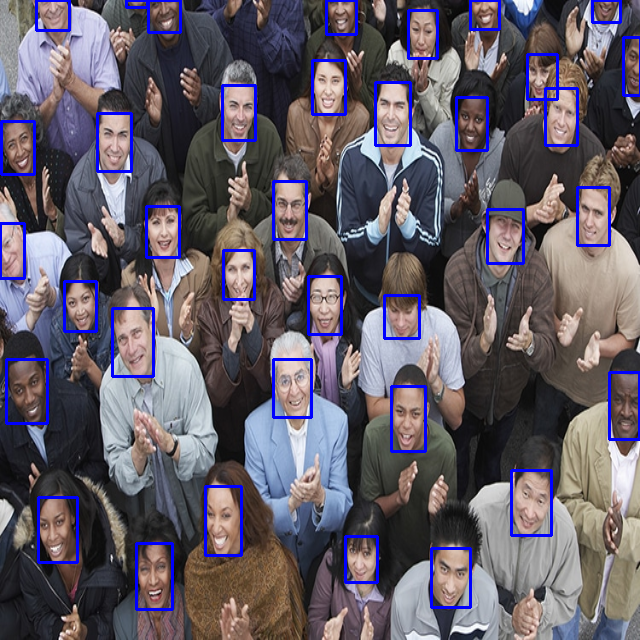

In [ ]:
import onnxruntime
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from urllib.request import Request, urlopen

palette = np.array([[255, 128, 0], [255, 153, 51], [255, 178, 102],
                    [230, 230, 0], [255, 153, 255], [153, 204, 255],
                    [255, 102, 255], [255, 51, 255], [102, 178, 255],
                    [51, 153, 255], [255, 153, 153], [255, 102, 102],
                    [255, 51, 51], [153, 255, 153], [102, 255, 102],
                    [51, 255, 51], [0, 255, 0], [0, 0, 255], [255, 0, 0],
                    [255, 255, 255]])
pose_kpt_color = palette[[16, 16, 16, 16, 16, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9]]
skeleton = [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 12],
            [7, 13], [6, 7], [6, 8], [7, 9], [8, 10], [9, 11], [2, 3],
            [1, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7]]

pose_limb_color = palette[[9, 9, 9, 9, 7, 7, 7, 0, 0, 0, 0, 0, 16, 16, 16, 16, 16, 16, 16]]
radius = 5

def pre_process(img, img_mean=127.5, img_scale=1/127.5):
    img = img[:, :, ::-1]
    img = cv2.resize(img, (640,640), interpolation=cv2.INTER_LINEAR)
    img = (img - img_mean) * img_scale
    img = np.asarray(img, dtype=np.float32)
    img = np.expand_dims(img,0)
    img = img.transpose(0,3,1,2)
    return img

def model_inference(model_path=None, input=None):
    #onnx_model = onnx.load(args.model_path)
    session = onnxruntime.InferenceSession(model_path, None)
    input_name = session.get_inputs()[0].name
    output = session.run([], {input_name: input})
    return output

def post_process(img, output, score_threshold=0.3):
    """
    Draw bounding boxes on the input image. Dump boxes in a txt file.
    """
    img = cv2.resize(img, (640,640))
    # det_bboxes, det_scores, det_labels, kpts = output[:, 0:4], output[:, 4], output[:, 5], output[:, 6:]
    det_bboxes, det_scores, det_labels = output[:, 1:5], output[:, -1], output[:, 0]
    clors = [(255,0,0),(0,255,0),(0,0,255),(255,255,0),(0,255,255)]
    #To generate color based on det_label, to look into the codebase of Tensorflow object detection api.
    for idx in range(len(det_bboxes)):
        det_bbox = det_bboxes[idx]
        # kpt = kpts[idx]
        if det_scores[idx]>score_threshold:
            # print("Conf", det_scores[idx], "DET", det_bbox)
            img = cv2.rectangle(img, (int(det_bbox[0]), int(det_bbox[1])), (int(det_bbox[2]), int(det_bbox[3])), (255,0,0), 2)
            # cv2.putText(img, "id:{}".format(int(det_labels[idx])), (int(det_bbox[0]+5),int(det_bbox[1])+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
            # cv2.putText(img, "score:{:2.1f}".format(det_scores[idx]), (int(det_bbox[0] + 5), int(det_bbox[1]) + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
    
            # for i in range(5):
            #     point_x = int(kpt[3 * i])
            #     point_y = int(kpt[3 * i + 1])
            #     conf = kpt[3*i + 2]
            #     if conf >  0.5:
            #         cv2.circle(img, (point_x, point_y), 2, clors[i], -1)
    
    cv2_imshow(img)


# model_path = "/content/yolov7-face/yolov7-tiny-face.onnx"
model_path = "/content/yolov7-face/out.onnx"
# "https://machinelearningmastery.com/wp-content/uploads/2019/03/test2.jpg"
# "https://mymodernmet.com/wp/wp-content/uploads/2020/10/facial-recognition-test.jpg"
# "https://hips.hearstapps.com/harpersbazaaruk.cdnds.net/15/37/original/original-david-gandy-jpg-5d012f79.jpg"
url="https://mymodernmet.com/wp/wp-content/uploads/2020/10/facial-recognition-test.jpg"
req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
arr = np.asarray(bytearray(urlopen(req).read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1) # 'Load it as it is'

input = pre_process(img, img_mean=0.0, img_scale=0.00392156862745098)
# input = pre_process(img)
output = model_inference(model_path, input)[0]
print(output[0])
post_process(img, output)

In [ ]:
!pip install onnx-tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 226 kB 5.1 MB/s 
     |████████████████████████████████| 1.1 MB 45.8 MB/s 


In [ ]:
from onnx_tf.backend import prepare
import onnx

onnx_model_path = "/content/yolov7-face/yolov7-tiny-face.onnx"
tf_model_path = '/content/model_tf'

onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)
tf_rep = prepare(onnx_model)
tf_rep.export_graph(tf_model_path)

In [ ]:
import tensorflow as tf

loaded = tf.saved_model.load(tf_model_path)
print(list(loaded.signatures.keys()))  # ["serving_default"]

infer = loaded.signatures["serving_default"]
print(infer.structured_outputs)
print(infer.inputs)

['serving_default']
{'onnx::Slice_757': TensorSpec(shape=(1, 3, 40, 40, 21), dtype=tf.float32, name='onnx::Slice_757'), '1431': TensorSpec(shape=(1, 25200, 21), dtype=tf.float32, name='1431'), 'onnx::Slice_1121': TensorSpec(shape=(1, 3, 20, 20, 21), dtype=tf.float32, name='onnx::Slice_1121'), 'onnx::Slice_393': TensorSpec(shape=(1, 3, 80, 80, 21), dtype=tf.float32, name='onnx::Slice_393')}
[<tf.Tensor 'images:0' shape=(1, 3, 640, 640) dtype=float32>, <tf.Tensor 'unknown:0' shape=(32, 3, 3, 3) dtype=float32>, <tf.Tensor 'unknown_0:0' shape=(32,) dtype=float32>, <tf.Tensor 'unknown_1:0' shape=(64, 32, 3, 3) dtype=float32>, <tf.Tensor 'unknown_2:0' shape=(64,) dtype=float32>, <tf.Tensor 'unknown_3:0' shape=(32, 64, 1, 1) dtype=float32>, <tf.Tensor 'unknown_4:0' shape=(32,) dtype=float32>, <tf.Tensor 'unknown_5:0' shape=(32, 64, 1, 1) dtype=float32>, <tf.Tensor 'unknown_6:0' shape=(32,) dtype=float32>, <tf.Tensor 'unknown_7:0' shape=(32, 32, 3, 3) dtype=float32>, <tf.Tensor 'unknown_8:0' s

In [ ]:
saved_model_dir = '/content/model_tf'
tflite_model_path = '/content/model.tflite'

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()

# Save the model
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

In [ ]:
tflite_interpreter = tf.lite.Interpreter(model_path=tflite_model_path)

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])
print(output_details)

== Input details ==
shape: [  1   3 640 640]
type: <class 'numpy.float32'>

== Output details ==
shape: [ 1  3 80 80 21]
type: <class 'numpy.float32'>
[{'name': 'StatefulPartitionedCall:2', 'index': 739, 'shape': array([ 1,  3, 80, 80, 21], dtype=int32), 'shape_signature': array([ 1,  3, 80, 80, 21], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'StatefulPartitionedCall:1', 'index': 751, 'shape': array([ 1,  3, 20, 20, 21], dtype=int32), 'shape_signature': array([ 1,  3, 20, 20, 21], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'StatefulPartitionedCall:0', 'index': 891, 'shape': array([    1, 25200,   

In [ ]:
print(output_details[2])

{'name': 'StatefulPartitionedCall:1', 'index': 751, 'shape': array([ 1,  3, 20, 20, 21], dtype=int32), 'shape_signature': array([ 1,  3, 20, 20, 21], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


In [ ]:
import numpy as np
input = np.random.rand(1,3,640,640).astype(np.float32)

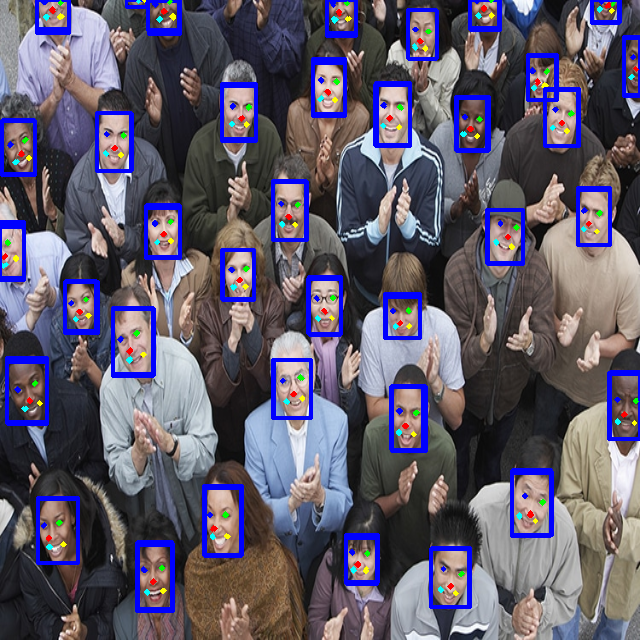

In [ ]:
import onnxruntime
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from urllib.request import Request, urlopen

palette = np.array([[255, 128, 0], [255, 153, 51], [255, 178, 102],
                    [230, 230, 0], [255, 153, 255], [153, 204, 255],
                    [255, 102, 255], [255, 51, 255], [102, 178, 255],
                    [51, 153, 255], [255, 153, 153], [255, 102, 102],
                    [255, 51, 51], [153, 255, 153], [102, 255, 102],
                    [51, 255, 51], [0, 255, 0], [0, 0, 255], [255, 0, 0],
                    [255, 255, 255]])
pose_kpt_color = palette[[16, 16, 16, 16, 16, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9]]
skeleton = [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 12],
            [7, 13], [6, 7], [6, 8], [7, 9], [8, 10], [9, 11], [2, 3],
            [1, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7]]

pose_limb_color = palette[[9, 9, 9, 9, 7, 7, 7, 0, 0, 0, 0, 0, 16, 16, 16, 16, 16, 16, 16]]
radius = 5

def pre_process(img, img_mean=127.5, img_scale=1/127.5):
    img = img[:, :, ::-1]
    img = cv2.resize(img, (640,640), interpolation=cv2.INTER_LINEAR)
    img = (img - img_mean) * img_scale
    img = np.asarray(img, dtype=np.float32)
    img = np.expand_dims(img,0)
    img = img.transpose(0,3,1,2)
    return img

def model_inference(model_path=None, input=None):
    tflite_interpreter = tf.lite.Interpreter(model_path=model_path)
    input_details = tflite_interpreter.get_input_details()
    output_details = tflite_interpreter.get_output_details()

    tflite_interpreter.allocate_tensors()
    tflite_interpreter.set_tensor(input_details[0]['index'], input)
    tflite_interpreter.invoke()
    output = tflite_interpreter.get_tensor(output_details[2]["index"])
    return output

def post_process(img, output, score_threshold=0.3):
    """
    Draw bounding boxes on the input image. Dump boxes in a txt file.
    """
    img = cv2.resize(img, (640,640))
    det_bboxes, det_scores, det_labels, kpts = output[:, 0:4], output[:, 4], output[:, 5], output[:, 6:]
    clors = [(255,0,0),(0,255,0),(0,0,255),(255,255,0),(0,255,255)]
    #To generate color based on det_label, to look into the codebase of Tensorflow object detection api.
    for idx in range(len(det_bboxes)):
        det_bbox = det_bboxes[idx]
        kpt = kpts[idx]
        if det_scores[idx]>score_threshold:
            # print("Conf", det_scores[idx], "DET", det_bbox)
            img = cv2.rectangle(img, (int(det_bbox[0]-det_bbox[2]/2), int(det_bbox[1]-det_bbox[3]/2)), (int(det_bbox[0]+det_bbox[2]/2), int(det_bbox[1]+det_bbox[3]/2)), (255,0,0), 2)
            # cv2.putText(img, "id:{}".format(int(det_labels[idx])), (int(det_bbox[0]+5),int(det_bbox[1])+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
            # cv2.putText(img, "score:{:2.1f}".format(det_scores[idx]), (int(det_bbox[0] + 5), int(det_bbox[1]) + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
    
            for i in range(5):
                point_x = int(kpt[3 * i])
                point_y = int(kpt[3 * i + 1])
                conf = kpt[3*i + 2]
                if conf >  0.5:
                    cv2.circle(img, (point_x, point_y), 2, clors[i], -1)
    
    cv2_imshow(img)


model_path = "/content/model.tflite"
# "https://machinelearningmastery.com/wp-content/uploads/2019/03/test2.jpg"
# "https://mymodernmet.com/wp/wp-content/uploads/2020/10/facial-recognition-test.jpg"
# "https://hips.hearstapps.com/harpersbazaaruk.cdnds.net/15/37/original/original-david-gandy-jpg-5d012f79.jpg"
url="https://mymodernmet.com/wp/wp-content/uploads/2020/10/facial-recognition-test.jpg"
req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
arr = np.asarray(bytearray(urlopen(req).read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1) # 'Load it as it is'

input = pre_process(img, img_mean=0.0, img_scale=0.00392156862745098)
# input = pre_process(img)
output = model_inference(model_path, input)[0]
post_process(img, output)

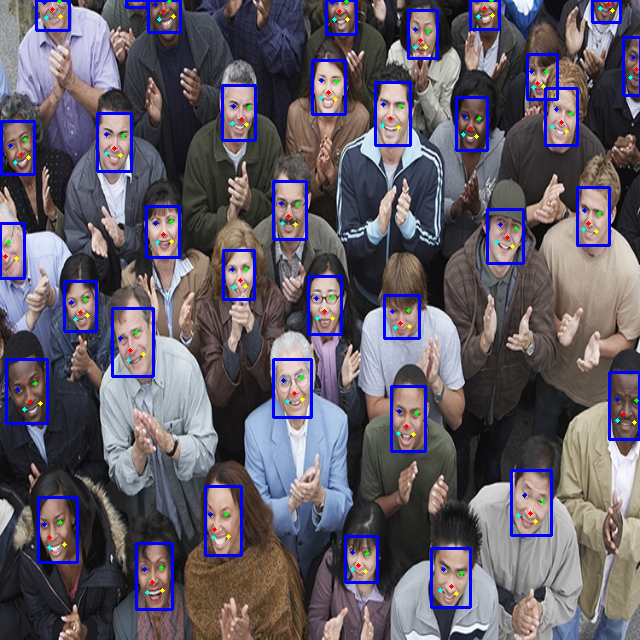

In [ ]:
def xywh_to_xyxy(output):
    for i in range(output.shape[0]):
        bbox = output[i, :4]
        x_min = bbox[0]-bbox[2]/2
        y_min = bbox[1]-bbox[3]/2
        x_max = bbox[0]+bbox[2]/2
        y_max = bbox[1]+bbox[3]/2
        output[i, :4] = [x_min, y_min, x_max, y_max]
    return output

def post_process(img, output, score_threshold=0.3):
    """
    Draw bounding boxes on the input image. Dump boxes in a txt file.
    """
    img = cv2.resize(img, (640,640))
    det_bboxes, det_scores, det_labels, kpts = output[:, 0:4], output[:, 4], output[:, 5], output[:, 6:]
    clors = [(255,0,0),(0,255,0),(0,0,255),(255,255,0),(0,255,255)]
    #To generate color based on det_label, to look into the codebase of Tensorflow object detection api.
    for idx in range(len(det_bboxes)):
        det_bbox = det_bboxes[idx]
        kpt = kpts[idx]
        if det_scores[idx]>score_threshold:
            # print("Conf", det_scores[idx], "DET", det_bbox)
            img = cv2.rectangle(img, (int(det_bbox[0]), int(det_bbox[1])), (int(det_bbox[2]), int(det_bbox[3])), (255,0,0), 2)
            # cv2.putText(img, "id:{}".format(int(det_labels[idx])), (int(det_bbox[0]+5),int(det_bbox[1])+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
            # cv2.putText(img, "score:{:2.1f}".format(det_scores[idx]), (int(det_bbox[0] + 5), int(det_bbox[1]) + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
    
            for i in range(5):
                point_x = int(kpt[3 * i])
                point_y = int(kpt[3 * i + 1])
                conf = kpt[3*i + 2]
                if conf >  0.5:
                    cv2.circle(img, (point_x, point_y), 2, clors[i], -1)
    cv2_imshow(img)

out = output.copy()
new_out = xywh_to_xyxy(out)

selected_indices = tf.image.non_max_suppression(
      new_out[:,0:4], new_out[:,4], 100)
# print(selected_indices.shape)
new_out = new_out[selected_indices]

post_process(img, new_out)